# Introduction

This notebook works through chapter 5 of the fastai book, which is a "deeper dive" into image classification. We will take a first pass at following the book linearly, followed by a second pass developing some working code in the form of a unified script or at least a `.org` file.

One aside: this represents my first use of the `juno` iPad app. The notebook server is running on my laptop, but I am working from my ipad. I am also testing a workflow wherein I am getting everything "working" on my laptop, and then pulling my git repo from a much more powerful remote machine with a GPU as needed.

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

# Data Setup
The first thing we need to do is figure out how the data are laid out and to set up our dataloaders accordingly. We start by investigating the structure of our downloaded data.

In [3]:
path.ls()

(#2) [Path('/home/djliden91/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images')]

We're going to ignore the "annotations" directory for now as it contains information on *where* the pets are while we're interested in *what* they are. So we will explore the `images` folder.

In [4]:
(path/"images").ls()

(#7393) [Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_96.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/Siamese_218.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/British_Shorthair_82.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/pug_115.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_97.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_42.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/great_pyrenees_123.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_185.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_103.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/german_shorthaired_184.jpg')...]

Now we need to figure out how to extract the breed names from the filenames. We have breed names (which may be more than one word, separated by underscores), followed by an underscore and a number (at least according to what we can see here so far).

We will use regular expressions to do this. The book notes that the name for regular expressions comes from Chomsky and that they're based, in some way, on his "Syntactic Structures."

In [5]:
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['english_cocker_spaniel']

OK, that worked for our single example. I'm unsure what the `r'` does, and the `(.+)` seems to get all characters before we hit an underscore and a `digit.jpg`, but I'm not entirely certain.
- `d` matches anty decimal digit.
- `+` matches the preceding argument one or more times. so `\d+` is matching *one or more digits*.
- `.` represents *any* single character, so `.+` represents one or more characters.
- parentheses identify a subexpression. When the parentheses are excluded, we also capture the number, which we don't want. It seems that, in this instance, the parentheses tell us *what* to capture, though I need to read up on how they do so.
- `r'` indicates a *raw string*. Regex makes liberal use of backslashes, and we don't want Python to attempt to interepret the backslash in any way before passing it to the regex function.

Now we will use our regular expression to label the full dataset.   

In [6]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=27),
                get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                item_tfms=Resize(460),
                batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

Some important transforms we have not worked with before:
- `item_tfms=Resize(460)` and `batch_tfms=aug_transforms(size=224, min_scale=0.75)`

Why are we taking this approach? If we perform the transformations and augmentations after scaling down to the training size, we risk significantly distorting our training samples, introducing empty areas, etc. So instead we pre-size all of our samples to a larger size, and then do all of the final augmentations and a resize in one step using (if available) the GPU.

In the `item_tfms` step, the image is cropped to the full width or height (at random). Note that the crop area in the validation set is *always* the center square of the image. The `batch_ftms` handles random cropping and other augmentations and the final resizing. Note that including `min_scale` in `batch_tfms` ensures `RandomResizedCrop` is added to `aug_transforms` automatically.   

## Debugging a DataBlock
Using the `show_batch()` method. Q: how does this work when you're *not* in a notebook environment?

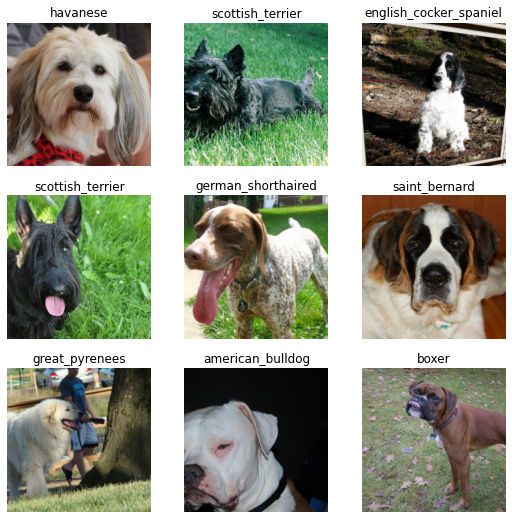

In [7]:
dls.show_batch(nrows=3, ncols=3)

We can also use the `summary` method to investigate our `DataBlock`

In [8]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/djliden91/.fastai/data/oxford-iiit-pet/images/newfoundland_95.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=333x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/djliden91/.fastai/data/oxford-iiit-pet/images/newfoundland_95.jpg
    applying partial gives
      newfoundland
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(27)

Final sample: (PILImage mode=RGB size=333x500, TensorCategory(27))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_ba

If we, for instance, forgot to resize our images (such that batch transforms were not possible), we would see an error at this point using the `summary` method.

## Training an initial model

JH recommends training an initial model sooner rather than later to catch any extremely obvious issues and to establish a baseline prior to any tweaking. So we're going to apply a CNN learner without messing with hyperparameters etc.

Trying to run this on my laptop makes it immediately clear that it will be much, much faster running this on my gcloud machine.

In [11]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(1)

KeyboardInterrupt: 

MUCH faster running this on GCC (to no one's surprise). And the workflow worked quite well. I stopped working locally and pushed my changes; pulled change to the GCC machine; and ran from that machine.

An extremely minor note: `metrics` takes a list, so we can pass `error_rate` and `accuracy` with no problems.

# Improving Our Model
Now, while we're here, I'm going to run the rest of the resource-intensive parts (mostly in the *improving our model* section), and then work through some of the examples and details locally to save money.

## The Learning Rate Finder
Tuning the learning rate is an important step in training the model. We'll start with a higher learning rate. The default is `.002`. A too-low learning rate can take many epochs to obtain good results. It may also result in overfitting -- "every time we do a complete pass through the data, we give our model a chance to memorize it."

So let's make our learning rate 50 times higher and see what happens.

In [13]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(1, base_lr = 0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.779952,6.144250,0.501353,0.498647,00:19


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.942251,2.667693,0.734777,0.265223,00:24


That did not work at all!

### Leslie Smith, Learning Rate Finder (2015)
General idea: start with a very small learning rate. Use for one mini-batch. Increase. Repeat. Keep doing this until the loss gets *worse* and then backtrack. JH recommends using a loss that is either:
- an order of magnitude lower than that at which the minimum loss was achieved; or
- the last point where the loss was clearly decreasing.

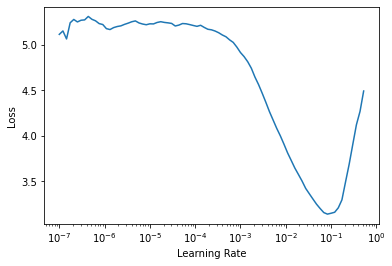

In [14]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
lr_min, lr_steep = learn.lr_find()

In [15]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 3.63e-03


It looks like a learning rate around `3e-3` would be good (it's in the steepest part of the graph, but not too near the bottom). So let's see if that improves our loss.

In [16]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.318479,0.362360,0.121110,0.878890,00:19


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.555252,0.384546,0.115697,0.884303,00:24
1,0.348184,0.282886,0.092693,0.907307,00:24


Our prior best accuracy was 92.6%. So this was actually worse. This also occurred in the book, but was not commented upon. At a lower lr, do we need more epochs? Let's try 4.

In [17]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(4, base_lr = 3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.279784,0.430575,0.137348,0.862652,00:19


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.477154,0.367555,0.113667,0.886333,00:24
1,0.427756,0.427707,0.110284,0.889716,00:24
2,0.263584,0.238910,0.079838,0.920162,00:24
3,0.156998,0.236129,0.075778,0.924222,00:24


We still actually ended up with a worse final accuracy. Odd!

## Unfreezing and Transfer Learning
Q: Page 207 describes us "throwing away the final linear layer and replacing it with a new one with the correct number of outputs for our desired task." Is this the "head"? Why isn't this terminology used explicitly here?

The newly-added linear layer (final layer) will be initialized with entirely random weights. So the initial model has entirely random outputs. So our task in transfer learning is to train a model that (1) "remembers" all of the useful image classificatrion ideas from the original pretrained model; and (2) can adjust them to be suited to our present task. When fine-tuning, we want to replace the random weights in our added linear layers **(why plural?)** with weights that are suited to our present task, *without* breaking the pretrained weights.

We accomplish this using a trick called "freezing." *Freezing* the pretrained layers means telling the model to update *only* the randomly-initialized final layer(s).

Fastai automatically freezes the pretrained layers when we use a pretrained network.

### What `fine_tune` does
When we call `fine_tune`, the following steps are followed:
- first, the randomly added layers are trained for one epoch with all other layers frozen.
- next, all of the layers are unfrozen and trained for the requested number of epochs.

## Manually training
We will take a more manual approach without `fine_tune`. We will use the `fit_one_cycle` method with the pretrained layers frozen, then unfreeze the layers, then train the whole model for more epochs.

In [18]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.112060,0.358614,0.110961,0.889039,00:19
1,0.524271,0.289095,0.091340,0.908660,00:19
2,0.308267,0.259686,0.088633,0.911367,00:19


In [19]:
# unfreeze the model
learn.unfreeze()

Now that we've unfrozen the model, we'll want to check the learning rate again. It is likely that the optimal learning rate will be quite different with more layers to train and with some weights already trained for several epochs.

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.3182567499825382e-06)

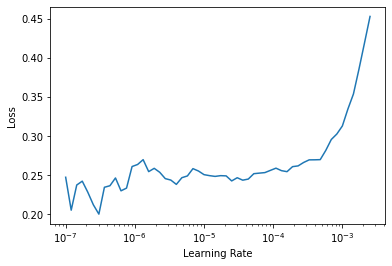

In [20]:
learn.lr_find()

We don't actually have an area of steep descent here. That's because the model has already been trained. It looks like we'll want an awfully small learning rate to subtly tweak the model. We will use `1e-5`.

In [21]:
learn.fit_one_cycle(6, lr_max = 1e-5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.253730,0.257234,0.087957,0.912043,00:24
1,0.229589,0.243798,0.085250,0.914750,00:24
2,0.226280,0.241649,0.081867,0.918133,00:24
3,0.202631,0.237476,0.083221,0.916779,00:24
4,0.200924,0.235051,0.079161,0.920839,00:24
5,0.170993,0.233388,0.077808,0.922192,00:24


Somehow we're still under the accuracy of our baseline naive approach.
### Discriminative Learning Rates
It doesn't actually make sense to use the same learning rates every step of the way. As we saw above, the learning rate for the randomly-initialized final layer(s) should be higher than for the already-trained layers. In general, we probably want later layers to fine-tune at higher rates than earlier layers. So fastai's default approach is to use discriminative learning rates. The core idea is that we let earlier layers learn at a lower rate than later layers. Presumably that's why our first "default" approach worked better? (yes -- checking documentation shows `fine_tune` uses discriminative lr).

We can manually specify a gradually changing learning rate if we want. We can pass a python `slice` instead of a single number. The first number in the slice is the initial learning rate; the second is the final; and the layers in between are trained at rates multiplicatively equidistant throughout the range.

In [23]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max = slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.097506,0.345274,0.110284,0.889716,00:19
1,0.532464,0.276283,0.085250,0.914750,00:19
2,0.312456,0.241748,0.079161,0.920839,00:19


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.258402,0.236900,0.079161,0.920839,00:24
1,0.242141,0.227061,0.075101,0.924899,00:24
2,0.227413,0.228965,0.074425,0.925575,00:24
3,0.217598,0.227170,0.073072,0.926928,00:24
4,0.183412,0.224241,0.072395,0.927605,00:24
5,0.175689,0.211329,0.071719,0.928281,00:24
6,0.158468,0.213776,0.074425,0.925575,00:24
7,0.146316,0.209605,0.071719,0.928281,00:24
8,0.139319,0.208525,0.071719,0.928281,00:24
9,0.133922,0.206454,0.073072,0.926928,00:24


We've finally done (marginally) better than the baseline.
## Selecting the Number of Epochs
- principle 1: if time-limited, fit the # of epochs that fit in your available time.
- old approach: would typically save the model after each epoch and then select the version that had the best accuracy ("early stopping"). But this probably doesn't give the best results with a variable learning rate -- the epochs in the middle were trained at a higher rate, and the most "detailed" optimization won't happen until we're at a lower learning rate. So better to retrain the whole model if you've overfit.
- If you have time for more epochs, you might be better off training more parameters by using...

## Deeper Architectures
Models with mroe layers can, in general, model your data more accurately, but they may also be prone to overfitting. It will also require more GPU RAM, so reducing batch size might be necessary. It also takes a lot longer. BUT we can use "mixed-precision training." We can use less-precise numbers (floating point 16, fp16). We're going to try `resnet50` with `fp16`.


In [24]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/djliden91/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.426769,0.313198,0.098106,00:32
1,0.596643,0.355872,0.117727,00:31
2,0.432136,0.309732,0.092693,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.267936,0.315203,0.086604,00:40
1,0.294756,0.381357,0.106901,00:40
2,0.254599,0.295936,0.081867,00:40
3,0.158779,0.243151,0.073748,00:40
4,0.092297,0.229402,0.069689,00:40
5,0.056558,0.224499,0.064953,00:40


The deeper model did give us a nontrivial improvement, with an accuracy of approx. 93.5% compared to a prior accuracy closer to 92.7%.

`freeze_epochs=3` tells `fine_tune` to freeze the first three epochs and then unfreeze. `fine_tune` also automatically changes learning rates in a way that is usually quite effective.

# Cross-Entropy Loss
Now we return to pafge 194-204 and work through some of the concepts that (hopefully) do not require so much work on the GPU.

`fastai` chooses a loss function based on the types of data used. In this case, with image inputs and categorical outcomes, the default is *cross-entropy loss*. So now we learn about that. Cross-entropy is similar to what we used for MNIST, but with two key benefits:
- works even with >2 dependent variable categories
- results in faster and more reliable training

## Viewing activations and labels
First we want to see what our data and activations actually look like. There are 37 pet breeds represented in this dataset. Getting one batch gives us 64 labels.

In [9]:
x,y = dls.one_batch()
y

TensorCategory([ 1, 32,  9,  7, 34,  6, 21, 31, 35, 29, 25, 26, 10, 13, 15,  1, 23, 20,
        28,  5, 20,  6, 23, 15,  1, 12, 14, 24, 36,  3,  9, 34, 26, 26,  7, 28,
        32, 22, 34,  3, 32, 31, 18,  6,  1, 26, 15, 36, 12, 35, 32, 16,  3, 20,
        14, 14, 28, 23, 23, 22,  6,  0, 20, 12])

We can get our predictions from the `learner`.

In [10]:
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

NameError: name 'learn' is not defined

This returns 37 probabilities between zero and one, representing the probability of each breed.

In [32]:
len(preds[0]), preds[0].sum()

(37, tensor(1.))

In [1]:
preds[0].argmax()

NameError: name 'preds' is not defined

In [36]:
dls.vocab[30]

'saint_bernard'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

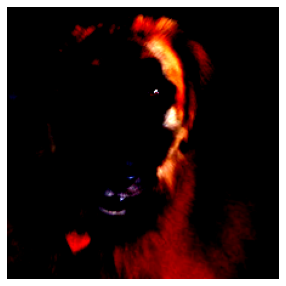

In [40]:
show_image(x[0])

### Softmax
Softmax is the "first part of cross-entropy loss."

We use the softmax function to ensure the activations in our final layer are all between zero and one and that they all sum to one. It returns one activation per category. We will demonstrate with some random numbers (we can pretend they represent a two-class problem).

In [57]:
acts = torch.randn((6,3))*2
acts

tensor([[-0.0124,  2.5399,  1.7704],
        [-3.5863,  1.6727, -1.9223],
        [-3.4684, -0.7148, -1.2084],
        [-1.2095, -0.0983,  4.1514],
        [-0.2329,  0.1869, -1.7653],
        [-1.9684, -2.2588,  1.3357]])

Now we can define the softmax function and apply it here.

In [53]:
import math
def softmax(x): return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

In [58]:
sm_acts = softmax(acts)
sm_acts

tensor([[0.0505, 0.6489, 0.3006],
        [0.0050, 0.9684, 0.0266],
        [0.0380, 0.5973, 0.3646],
        [0.0046, 0.0140, 0.9814],
        [0.3653, 0.5558, 0.0789],
        [0.0345, 0.0258, 0.9397]])

In [60]:
# first cell manual
math.exp(-0.0124)/(math.exp(-0.0124) + math.exp(2.5399) + math.exp(1.7704))

0.05054825316405919

### Log Likelihood
